# Goal: To predict MoA annotations based on drug's biological response

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Acquire and summarize the training dataset

In [3]:
# Acquire the training dataset

df = pd.read_csv("train_features.csv")
df.shape

(23814, 876)

In [3]:
# Take a look at the columns

df.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
df.sig_id.value_counts().size

23814

### cp_type
**It indicates how the samples are treated: either with small-molecule compounds(trt_cp) or with a control perturbation (ctrl_vehicle). Control pertubations have no MoAs.**

In [5]:
# Count the unique values of cp_type

count_cptype = df.cp_type.value_counts()
count_cptype

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64

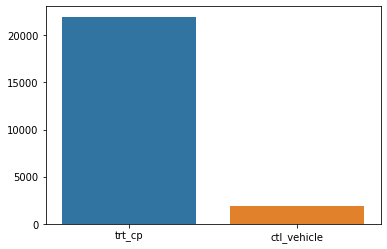

In [6]:
# Barplot the count_cptype

sns.barplot(x=count_cptype.index, y=count_cptype.values)

In [11]:
# Subset the df containing ctl_vehicle only

mask_cptype = (df.cp_type == 'ctl_vehicle')
df_ctl = df[mask_cptype]
df_ctl.shape

(1866, 876)

In [12]:
# Subset the df_ctl containing c-# only

df_ctl_cv = df_ctl.loc[:, 'c-0': 'c-99']
df_ctl_cv.shape

(1866, 100)

In [15]:
# Subset the df containing the treated samples only

df_trt = df[-mask_cptype]
df_trt.shape

(21948, 876)

In [16]:
# Substract the df_trt containing c-# only

df_trt_cv = df_trt.loc[:, 'c-0': 'c-99']
df_trt_cv.shape

(21948, 100)

In [18]:
# Compute the descriptive statistic of the cell viability in df_ctrl

df_ctl_cv.mean().agg(['mean','median','std'])

mean      0.167753
median    0.170227
std       0.089470
dtype: float64

In [19]:
# Compute the descriptive statistic of the cell viability in df_trt

df_trt_cv.mean().agg(['mean','median','std'])

mean     -0.483241
median   -0.503468
std       0.102909
dtype: float64

In [6]:
df.cp_time.value_counts()

48    8250
72    7792
24    7772
Name: cp_time, dtype: int64

In [7]:
df.cp_dose.value_counts()

D1    12147
D2    11667
Name: cp_dose, dtype: int64

**Takeaways**
1. The trainning dataset has **23814 rows** and **876 columns**.
2. Cols: 
    - sig_id: MoA response(s) of 23814 samples
    - g- signify gene expression data
    - c- signify cell viability data
    - cp_type: indicates samples treated with a compound or with a control perturbation
        - trt_cp: 21948
        - ctl_vehicle: 1866
    - cp_time indicates treatment duration:
        - 24: 7772
        - 48: 8250
        - 72: 7792
    - cp_does indicates treatment dose:
        - D1: 12147
        - D2: 11667   
3. I need to figure out what g-number and c-number means.

In [18]:
# Create a mask for cell viability cols only

mask_viability = df.columns.str.contains('c-')

df_cell_viability = df.iloc[:, mask_viability]
df_cell_viability.shape

(23814, 100)

In [20]:
df_cell_viability.describe()

,c-0,c-1,c-2,c-3,c-4,c-5,c-6,c-7,c-8,c-9,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,-0.355156,-0.455359,-0.480542,-0.377666,-0.493552,-0.446037,-0.574855,-0.266293,-0.451307,-0.458664,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,1.752565,2.004962,2.039346,1.554583,2.091888,1.893484,2.234152,1.465313,1.948829,1.646122,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.549300,-0.538425,-0.550375,-0.601975,-0.559975,-0.578775,-0.571250,-0.524275,-0.551100,-0.654675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,-0.009000,0.009800,-0.004000,-0.039050,0.011400,-0.008900,0.007400,0.006350,-0.005350,-0.025350,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,0.448975,0.476875,0.460575,0.413100,0.470300,0.442675,0.459475,0.469375,0.453175,0.424400,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,3.365000,3.915000,2.970000,2.408000,4.555000,3.614000,3.904000,4.918000,3.648000,3.194000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


**Takeaways**
1. The cell viability has 100 columns. 
    - **Does indicate there are 100 different cell lines?**
    - **Yes**, it is.
2. The min is -10.0 for all the columns. 
    - **I thought the min is 0. why negative number?** 
3. The max is different among the columns. 
    - **Do I need to sacle the data?**

In [21]:
# Create a mask for gene expression cols only

mask_gene_expression = df.columns.str.contains('g-')

df_gene_expression = df.iloc[:, mask_gene_expression]
df_gene_expression.shape

(23814, 772)

In [28]:
df_gene_expression.iloc[:, 0:4].describe()

,g-0,g-1,g-2,g-3
count,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.248366,-0.095684,0.152253,0.081971
std,1.393399,0.812363,1.035731,0.950012
min,-5.513000,-5.737000,-9.104000,-5.998000
25%,-0.473075,-0.562200,-0.437750,-0.429575
50%,-0.008850,-0.046600,0.075200,0.008050
75%,0.525700,0.403075,0.663925,0.463400
max,10.000000,5.039000,8.257000,10.000000


In [29]:
df_gene_expression.head()

,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,...,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,...,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,...,-0.5338,0.0224,-0.4831,0.2128,-0.6999,-0.1214,-0.1626,-0.3340,-0.3289,-0.2718
2,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,...,2.5770,0.2356,1.3230,-1.3730,-0.2682,0.8427,0.5797,0.3143,0.8133,0.7923
3,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,...,-0.1292,3.4310,1.2720,-0.4733,-2.0560,0.5699,0.1996,0.4374,0.1588,-0.0343
4,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,...,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269


**Takeaways**
- There are 772 gene expressions. 
- What does the number mean? 

### Summarize Targests 

In [33]:
# Read train_targets_scored.csv

df_score = pd.read_csv("train_targets_scored.csv")
df_score.shape

(23814, 207)

In [59]:
df_score.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Count the total number of MoA annotations

df_score.columns.size - 1

206

In [63]:
# Group MoA annotations based on the counts.

df_score.sum(axis=1).value_counts().sort_index()

0     9367
1    12532
2     1538
3      303
4       55
5       13
7        6
dtype: int64

**Takeways**
- 206 MoA targets.